# Nonstructural Seismic Fragility Tool 
This notebook allows users to visualize data within the experimental.csv database and use that data to estimate fragility functions of specific nonstrcutural building components of interest. The tool fits fragilities using the maximum liklihood estimation method, assuming a lognormal distribution, and uses Notebook Widgets to ehnance user interaction without needing to change the code.

After running each cell in this notebook, users can easily vary inputs using the dropdown widgets to query different component types within the database.

Prior to running script ensure that all required packages are installed by running the following commands on your command line
 - pip install numpy
 - pip install scipy
 - pip install pandas
 - pip install matplotlib
 - pip install ipywidgets

## Import packages

In [1]:
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets

## Load database
Pull in the experimental observations database csv in the data directory

In [4]:
df = pd.read_csv('../data/db_experiment.csv')

## Characterize Data
Plot a categorical histogram of the number of datapoints available for each component type in the database.

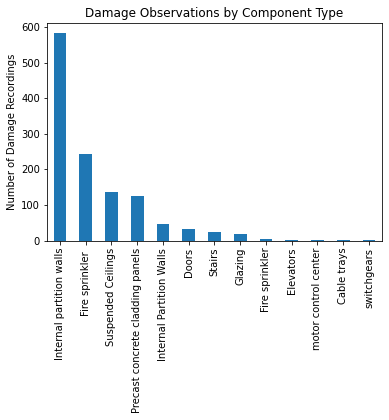

In [7]:
ax = df['comp_type'].value_counts(sort=True).plot.bar(rot=90, title='Damage Observations by Component Type')
ax.set_ylabel("Number of Damage Recordings");
comp_types = df['comp_type'].unique()
edp_types = df['edp_metric'].unique()

## Select Component Type and Fit Fragility
From one the available component types listed in the above plot, investigate the damage data and fit a lognormal fragility curve.

### Plot Distribution of Damage Records
In the dropdowns below, select a component type of interest and an applicable EDP parameter. The second drop down only shows EDPs that are available in the database for the selected component type (i.e., they are conditional on the first dropdown). The plot shows a discrete pdf (histogram) of the intesity at which the damaged occured across all expermintal test in the database for a given EDP

In [9]:
def check_intensity(comptype="Suspended Ceilings",edp='PFA (g), Horizontal in longitudinal direction'):
    newdf = df[(df['comp_type'] == comptype) & (df['edp_metric'] == edp)]
    convert_data = newdf[['edp_value']].apply(pd.to_numeric)
    ax = convert_data.plot.hist(column=["edp_value"], title='Component Capacity')
    ax.set_xlabel(edp);

def get_edp_types_per_selected_comptype(comptype="Suspended Ceilings"):
    newdf = df[(df['comp_type'] == comptype)]
    value_counts = newdf['edp_metric'].value_counts(sort=True)
    edp_types_per_selected_comptype = value_counts.index.to_list()
    return edp_types_per_selected_comptype


def update_edp_options(comptype):
    edp_types_per_selected_comptype = get_edp_types_per_selected_comptype(comptype)
    
    widgets.interact(check_intensity, comptype=widgets.fixed(comptype), edp=edp_types_per_selected_comptype)

In [10]:
widgets.interact(update_edp_options, comptype=comp_types);

interactive(children=(Dropdown(description='comptype', options=('Internal partition walls', 'Precast concrete …

### Fit Seismic Fragility
In th drop Using MLE, fit a lognormal fragility to the discrete damage points for a given component type and EDP of interest. In the dropdowns below, select a component type of interest and an applicable EDP parameter. The second drop down only shows EDPs that are available in the database for the selected component type (i.e., they are conditional on the first dropdown). The plot shows the discrete cdf points overlayed by the fitted fragility. Fragility parameters $\mu$ (median) and $\beta$ (lognormal standard deviation) are printed just above the plot. 

*Note: The current fitting proceduce is very basic and will likely provide poor fits for data smaller than 30 points.*

In [11]:
def fit_frag(comptype="Suspended Ceilings",edp='PFA (g), Horizontal in longitudinal direction'):
    newdf = df[(df['comp_type'] == comptype) & (df['edp_metric'] == edp)]
    if newdf.size > 0:
        convert_data = newdf[['edp_value']].apply(pd.to_numeric)

        # Rank the data
        ranked_data = convert_data.sort_values(by='edp_value')
        num_records = ranked_data.size
        ranked_data['rank'] = np.linspace(1, num_records, num=num_records)/num_records

        # Fit the fragility
        up_lim = ranked_data['edp_value'].max()
        x=np.linspace(0,up_lim,100)
        param = sp.stats.lognorm.fit(ranked_data['edp_value'])
        cdf_fitted = sp.stats.lognorm.cdf(x, param[0], loc=param[1], scale=param[2]) # fitted distribution

        # Plot the data
        ax = ranked_data.plot.scatter(x='edp_value', y='rank')
        plt.plot(x,cdf_fitted,'r-')
        ax.set_xlabel(edp);

        # Print the Fragility Parameters
        print('μ = ', round(param[2],3))
        print('β = ', round(param[0],2))
    else:
      print("No Damage Records")


def get_edp_types_per_selected_comptype(comptype="Suspended Ceilings"):
    newdf = df[(df['comp_type'] == comptype)]
    value_counts = newdf['edp_metric'].value_counts(sort=True)
    edp_types_per_selected_comptype = value_counts.index.to_list()
    return edp_types_per_selected_comptype

def update_edp_options(comptype):
    edp_types_per_selected_comptype = get_edp_types_per_selected_comptype(comptype)
    
    widgets.interact(fit_frag, comptype=widgets.fixed(comptype), edp=edp_types_per_selected_comptype)

In [12]:
widgets.interact(update_edp_options, comptype=comp_types);

interactive(children=(Dropdown(description='comptype', options=('Internal partition walls', 'Precast concrete …